**CS 330 Autumn 2019/2020 Homework 1**
**Data Processing and Memory Augmented Neural Networks**


Overview¶

In this assignment we will be looking at meta-learing for few shot classification.

You will

    Learn how to process and partition data for meta learning problems, where training is done over a distribution of training tasks $p(\mathcal T)$.

    Implement and train memory augmented neural networks, which meta-learn through a recurrent network.

    Analyze the learning performance for different size problems.

    Experiment with model parameters and explore how they improve performance.

We will be working with the Omniglot dataset [1] , a dataset for one-shot learning which contains:

    1623 different characters (classes)

    from 50 different languages.

    For each character there are 20 $28 \times 28$ images.

We are interested in training models for K-shot, N-way classification, that is, we want to train a classifier to distinguish between N previously unseen characters, given only K labeled examples of each character.
Submission:

To submit your homework, submit one pdf report and one zip file to Grade-Scope, where the report will contain answers to the deliverables listed below and the zip filecontains your code (hw1.py, load_data.py) with the filled in solutions.
Code Overview: The code consists of two files

    load_data.py: Contains code to load batches of images and labels

    hw1.py: Contains the network architecture/loss functions and training script.

There is also the omniglot resized folder which contains the data. You should not modify this folder.
Dependencies:

We expect code in Python 3.5+ with Pillow, scipy, numpy, tensorflow installed.
Problem 1: Data Processing for Few-Shot Classification

Before training any models, you must write code to sample batches for training. Fill in the sample batch function in the DataGenerator class in the load_data.py file.

The class already has variables defined for

    batch size batch_size ( $B$ ),

    number of classes num_classes ( $N$ ),

    and number of samples per class num_samples_per_class ( $K$ ).

Your code should:

    Sample $N$ different classes (characters) from either the specified train, test, or validation folders.

    Load $K$ images per class and collect the associated labels.

    Format the data and return two numpy matrices:

        one of flattened images with shape $[ B, K, N, 784 ]$,

        and one of one-hot labels $[ B, K, N, N ]$



In [1]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

Unzipping...Done.


In [41]:
import os
import imageio
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import datetime

In [3]:
decoder = lambda x: image if type(image) is not bytes else image.decode('UTF-8')

In [4]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths:  A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
        
    images_labels = [(i, os.path.join(path, image.decode('UTF-8')))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

In [5]:
class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        np.random.seed(1)
        np.random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
                                         num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
                                          num_train + num_val:]

    def sample_batch(self, batch_type, batch_size, shuffle=True):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        B = batch_size
        N = self.num_classes
        K = self.num_samples_per_class
        I = self.dim_input
        all_image_batches = []
        all_label_batches = []
        
        # 0. Repeat for B batches
        for batch in range(B):
            # 1. Sample N different classes
            n_classes = np.random.choice(folders, N, replace=False)
            tuples = get_images(n_classes, range(N), nb_samples=K, shuffle=False) # <! False? 
            
            images = [image_file_to_array(im, I) for lb,im in tuples]
            images = np.stack(images)
            images = np.reshape(images, (N, K, I))
            
            
            
            labels = np.asarray([lb for lb, im in tuples])
            labels = np.reshape(labels, (N, K))
            labels = np.eye(N)[labels]
            
            
            
            labels = np.swapaxes(labels, 0, 1)
            images = np.swapaxes(images, 0, 1)
            
            
            all_image_batches.append(images)
            all_label_batches.append(labels)
        all_image_batches = np.stack(all_image_batches)
        all_label_batches = np.stack(all_label_batches)
        return all_image_batches, all_label_batches

In [6]:
num_classes=5
num_samples_per_class=3

data = DataGenerator(num_classes, num_samples_per_class)

In [7]:
images, labels = data.sample_batch('train', batch_size=2, shuffle=False)
print("Batch of images of shape:", images.shape)
print("Batch of labels of shape:", labels.shape)

Batch of images of shape: (2, 3, 5, 784)
Batch of labels of shape: (2, 3, 5, 5)


In [8]:
for i in range(num_classes):
    print(labels[0,0,i])


[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]


First meta-batch:


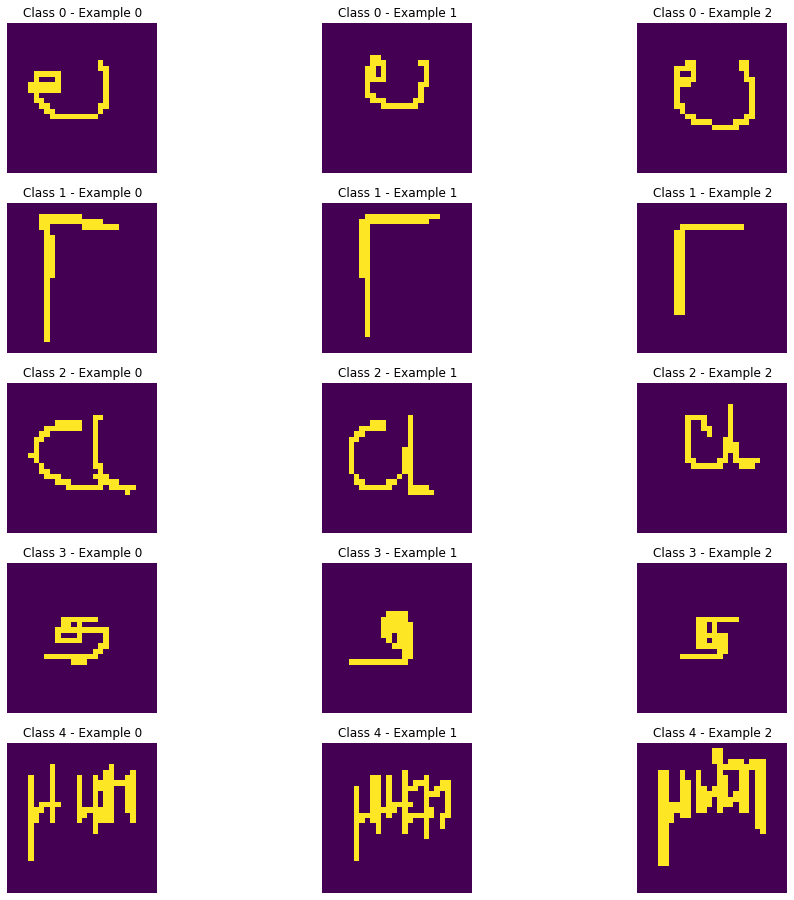

In [10]:
print("First meta-batch:")

plt.figure(figsize=(16, 16))
count = 0
for cl in range(num_classes):
    for sa in range(num_samples_per_class):
        plt.subplot(num_classes, num_samples_per_class, count + 1)
        plt.title("Class {} - Example {}".format(cl, sa))
        image = images[0, sa, cl].reshape((28,28))
        plt.imshow(image)
        plt.axis('off');
        count += 1
plt.show()

Second meta-batch:


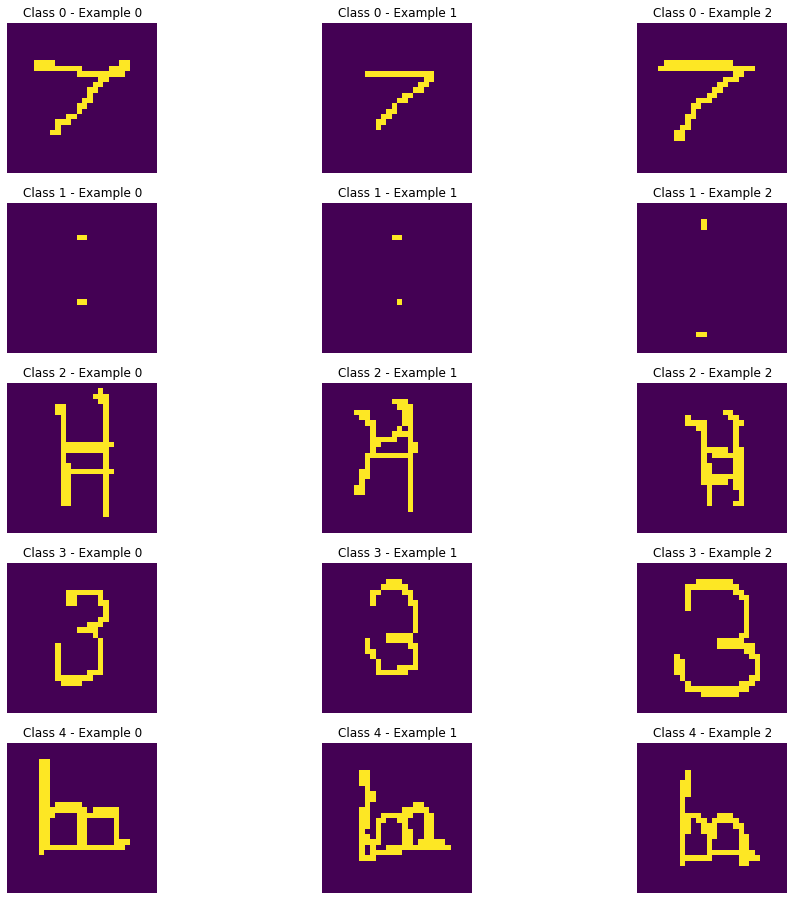

In [11]:
print("Second meta-batch:")

plt.figure(figsize=(16, 16))
count = 0
for cl in range(num_classes):
    for sa in range(num_samples_per_class):
        plt.subplot(num_classes, num_samples_per_class, count + 1)
        plt.title("Class {} - Example {}".format(cl, sa))
        image = images[1, sa, cl].reshape((28,28))
        plt.imshow(image)
        plt.axis('off');
        count += 1
plt.show()

About the Data Generator

In [12]:
print("# of samples per class:", data.num_samples_per_class)
print("# of classes:",  data.num_classes)
print("Image size:",   data.img_size)
print("Input dimension:",  data.dim_input)
print("Output dimension:", data.dim_output)


# of samples per class: 3
# of classes: 5
Image size: (28, 28)
Input dimension: 784
Output dimension: 5


In [13]:
print("# of meta train folders:", len(data.metatrain_character_folders))
print("# of meta val folders:  ", len(data.metaval_character_folders))
print("# of meta test folders: ", len(data.metatest_character_folders))

# of meta train folders: 1100
# of meta val folders:   100
# of meta test folders:  423


In [14]:
classes = np.asarray(data.metatest_character_folders[0:3])
labels  = [0, 1 ,2]
get_images(classes, labels, 1)


[(0, './omniglot_resized/Manipuri/character07/1325_11.png'),
 (1, './omniglot_resized/Glagolitic/character30/1144_02.png'),
 (2, './omniglot_resized/Asomtavruli_(Georgian)/character21/0088_15.png')]

In [15]:
[os.path.basename(os.path.split(family)[0]) for family in data.metatest_character_folders[0:3]]

['Manipuri', 'Glagolitic', 'Asomtavruli_(Georgian)']

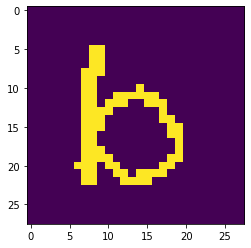

In [16]:
plt.imshow(image_file_to_array('./omniglot_resized/N_Ko/character12/0815_17.png', 784).reshape((28,28)))
plt.show()


Problem 2: Memory Augmented Neural Networks [2] [3]

We will be attempting few shot classification using memory augmented neural networks.

The idea of memory augmented networks is:

    $$\Large \text{to use a classifier with } \underline{\text{recurrent memory}}, \\ \ \\ \Large \text{such that }\underline{\text{information from the K examples of unseen classes}}\\ \ \\ \Large \underline{\text{informs classification through the hidden state of the network}}$$ 

The data processing will be done as in SNAIL [3].

Specifically, during training, you sample batches of $N$ classes, with $K + 1$ samples per batch.

Each set of labels and images are concatenated together, and then all K of these concatenated pairs are sequentially passed through the network.

Then the final example of each class is fed through the network (concatenated with 0 instead of the true label).

figure-1.png

The loss is computed between these final outputs and the ground truth label, which is then backpropagated through the network.

    Note: The loss is only computed on the last set of $N$ classes.

The idea is that the network will learn how to encode the first $K$ examples of each class into memory such that it can be used to enable accurate classification on the $K + 1th$ example. See Figure 1.

In the hw1.py file:

    Fill in the call function of the MANN class to take in image tensor of shape $[B, K + 1, N, 784]$ and a label tensor of shape $[B, K + 1, N, N ]$ and output labels of shape $[B, K + 1, N, N ]$.

    The layers to use have already been defined for you in the init function.

    Hint: Remember to pass zeros, not the ground truth labels for the final $N$ examples.

    Fill in the function called loss_function which takes as input the $[B, K + 1, N, N ]$ labels and $[B, K + 1, N, N ]$ and computes the cross entropy loss.

Note: Both of the above functions will need to backpropogated through, so they need to be written in differentiable tensorflow.

In [24]:
tf.__version__

'2.5.0'

In [51]:
def loss_function(preds, labels):
    """l
    Computes MANN loss
    Args:
        preds: [B, K+1, N, N] network output
        labels: [B, K+1, N, N] labels
    Returns:
        scalar loss
    """
    loss = tf.keras.losses.categorical_crossentropy(y_true=labels[:,-1:,:,:],
                                                    y_pred=preds[:, -1:,:,:],
                                                    from_logits=True)
    loss = tf.reduce_sum(loss)
    return loss

class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        # [:,:,:,784],[:,:,:,5] => [:,:,:,789]
        _, K, N, I = input_images.shape
        # Zero last N example, corresponding to the K+1 sample
        # Note the '-1'+':,' so num of dimensions keeps equal
        in_zero = input_labels - input_labels[:, -1:, :, :]
        input_concat = tf.keras.layers.Concatenate(axis=3)([input_images, in_zero])
        input_concat = tf.reshape(input_concat, [-1, K*N, N + 28*28])
        out = self.layer2(self.layer1(input_concat))
        out = tf.reshape(out, [-1, K, N, N])
        #############################
        return out

In [52]:
def run_experiment(num_classes=2, num_samples=1, meta_batch_size=1, epochs=5e5, verbose=True):
    #Placeholders for images and labels
    ims = tf.placeholder(tf.float32,
                shape=(None,
                       num_samples + 1,
                       num_classes,
                       784))
    labels = tf.placeholder(tf.float32,
                shape=(None,
                       num_samples + 1,
                       num_classes,
                       num_classes))

    data_generator = DataGenerator(
                        num_classes,
                        num_samples + 1)

    o = MANN(num_classes, num_samples + 1)
    out = o(ims, labels)

    loss = loss_function(out, labels)

    optim = tf.train.AdamOptimizer(0.001)
    #optim = tf.compat.v1.train.AdamOptimizer(0.001)
    optimizer_step = optim.minimize(loss)
    print("... Starts training ...")
    last_time = datetime.datetime.now()
    print("Time:", last_time.time())
    history = []
    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        
        for step in range(int(epochs)):
            i, l = data_generator.sample_batch(batch_type='train', batch_size=meta_batch_size)
            #print("i.shape:",i.shape)
            feed = {ims:    i.astype(np.float32),
                    labels: l.astype(np.float32)}
            #print("feed[ims].shape:", feed[ims].shape)
            _, ls = sess.run([optimizer_step, loss], feed)

            if step % 100 == 0 or step == int(epochs)-1:
                if verbose:
                    print("***** Iter {} *****".format(step))
                    print("Took {:.4f} seconds".format(((datetime.datetime.now() - last_time).microseconds)*1e-5))
                last_time = datetime.datetime.now()
                i, l = data_generator.sample_batch(batch_type='test', batch_size=1000)
                feed = {ims:    i.astype(np.float32),
                        labels: l.astype(np.float32)}
                pred, tls = sess.run([out, loss], feed)
                if verbose:
                    print("Train Loss:", ls)
                    print("Test  Loss:", tls)
                pred = pred.reshape(
                        -1, num_samples + 1,
                        num_classes, num_classes)
                pred = pred[:, -1, :, :].argmax(2)
                l = l[:, -1, :, :].argmax(2)
                
                accuracy = (1.0 * (pred == l)).mean()
                history.append([step, ls, tls, accuracy])
                if verbose:
                    print("Test Accuracy", accuracy)
                    
                
    print("Time:", last_time.time())
    print("... Training ended ...")
    return np.asarray(history, dtype=np.float32)

In [53]:
# Number of classes used in classification (e.g. 5-way classification).
num_classes = 5

# Number of examples used for inner gradient update (K for K-shot learning)
num_samples = 1

# Number of N-way classification tasks per batch
meta_batch_size = 4

hist = run_experiment(epochs=1e3)

... Starts training ...
Time: 12:13:06.011657
***** Iter 0 *****
Took 4.4748 seconds
Train Loss: 1.3671381
Test  Loss: 1378.3389
Test Accuracy 0.508
***** Iter 100 *****
Took 9.6675 seconds
Train Loss: 0.64946043
Test  Loss: 717.9373
Test Accuracy 0.945
***** Iter 200 *****
Took 8.3708 seconds
Train Loss: 0.49040774
Test  Loss: 533.9633
Test Accuracy 0.9895
***** Iter 300 *****
Took 7.9655 seconds
Train Loss: 0.48369592
Test  Loss: 517.7283
Test Accuracy 0.992
***** Iter 400 *****
Took 8.4110 seconds
Train Loss: 0.47089875
Test  Loss: 496.6395
Test Accuracy 0.991
***** Iter 500 *****
Took 8.3676 seconds
Train Loss: 0.47597927
Test  Loss: 519.2595
Test Accuracy 0.9845
***** Iter 600 *****
Took 8.3121 seconds
Train Loss: 0.46840075
Test  Loss: 482.49487
Test Accuracy 0.9945
***** Iter 700 *****
Took 8.2352 seconds
Train Loss: 0.4688631
Test  Loss: 491.56467
Test Accuracy 0.9905
***** Iter 800 *****
Took 7.7584 seconds
Train Loss: 0.46650195
Test  Loss: 479.47543
Test Accuracy 0.9955
****

In [54]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

steps = hist[:,0]
train_losses = hist[:,1]
test_losses  = hist[:,2]
test_accurs  = hist[:,3]

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Training Loss", "Test Loss", "Test Accuracy", "Losses"))
fig.add_trace(go.Scatter(x=steps, y=train_losses, name='Train Loss', line=dict(color="blue")),
              row=1, col=1
              )
fig.add_trace(go.Scatter(x=steps, y=test_losses, name='Test Loss', line=dict(color="red")),
              row=1, col=2
              )
fig.add_trace(go.Scatter(x=steps, y=test_accurs, name='Test Acc'),
              row=2, col=1
              )
fig.add_trace(go.Scatter(x=steps, y=train_losses, name='Train Loss', line=dict(color="blue")),
              row=2, col=2
              )
fig.add_trace(go.Scatter(x=steps, y=test_losses, name='Test Loss', line=dict(color="red")),
              row=2, col=2
              )
fig.update_layout(height=1000, title_text="Performance over time")
fig.show()


In [55]:
hist = run_experiment(num_classes=2, num_samples=1, meta_batch_size=4, epochs=1e4, verbose=False)

... Starts training ...
Time: 12:15:13.837327
Time: 12:20:26.005138
... Training ended ...


In [56]:
steps = hist[:,0]
train_losses = hist[:,1]
test_losses  = hist[:,2]
test_accurs  = hist[:,3]


In [57]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Training Loss", "Test Loss", "Test Accuracy", "Losses"))
fig.add_trace(go.Scatter(x=steps, y=train_losses, name='Train Loss', line=dict(color="blue")),
              row=1, col=1
              )
fig.add_trace(go.Scatter(x=steps, y=test_losses, name='Test Loss', line=dict(color="red")),
              row=1, col=2
              )
fig.add_trace(go.Scatter(x=steps, y=test_accurs, name='Test Acc'),
              row=2, col=1
              )
fig.add_trace(go.Scatter(x=steps, y=train_losses, name='Train Loss', line=dict(color="blue")),
              row=2, col=2
              )
fig.add_trace(go.Scatter(x=steps, y=test_losses, name='Test Loss', line=dict(color="red")),
              row=2, col=2
              )
fig.update_layout(height=1000, title_text="Performance over time")
fig.show()

In [58]:
hist = run_experiment(num_classes=4, num_samples=5, meta_batch_size=4, epochs=1e4, verbose=False)

... Starts training ...
Time: 12:22:19.124893
Time: 12:47:39.118231
... Training ended ...


In [59]:
steps = hist[:,0]
train_losses = hist[:,1]
test_losses  = hist[:,2]
test_accurs  = hist[:,3]


In [60]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Training Loss", "Test Loss", "Test Accuracy", "Losses"))
fig.add_trace(go.Scatter(x=steps, y=train_losses, name='Train Loss', line=dict(color="blue")),
              row=1, col=1
              )
fig.add_trace(go.Scatter(x=steps, y=test_losses, name='Test Loss', line=dict(color="red")),
              row=1, col=2
              )
fig.add_trace(go.Scatter(x=steps, y=test_accurs, name='Test Acc'),
              row=2, col=1
              )
fig.add_trace(go.Scatter(x=steps, y=train_losses, name='Train Loss', line=dict(color="blue")),
              row=2, col=2
              )
fig.add_trace(go.Scatter(x=steps, y=test_losses, name='Test Loss', line=dict(color="red")),
              row=2, col=2
              )
fig.update_layout(height=1000, title_text="Performance over time")
fig.show()